## Initialising the Variables


In [3]:
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd

# New board sizes: 8x8 to 20x20 in increments of 2
BOARD_SIZES = [8*8, 10*10, 12*12, 14*14, 16*16, 18*18, 20*20]
NUM_SNAKES_LADDERS_DENSITY = 0.1  # Density for snakes and ladders
FIXED_SNAKE_LENGTH = 10  # Changed from 11 to 10 per requirements
FIXED_LADDER_LENGTH = 10  # Changed from 11 to 10 per requirements
NUM_SIMULATIONS = 10000  # Number of simulations per configuration
NS_NL_RATIOS = [0.5, 1.0, 1.5, 2.0]  # Ns/Nl Ratio values

## Create the Board


In [4]:
def create_snakes_and_ladders(board_size, num_snakes, num_ladders, fixed_snake_length=FIXED_SNAKE_LENGTH, fixed_ladder_length=FIXED_LADDER_LENGTH):
    """
    Generates random positions for snakes and ladders with FIXED lengths.
    Simplified version without board connectivity checks.
    """
    snakes = {}
    ladders = {}
    used_tiles = set()

    def generate_endpoints(entity_type, used_tiles, board_size, fixed_snake_length, fixed_ladder_length):
        attempts = 0
        while attempts < 100:
            attempts += 1
            if entity_type == "snake":
                start_tile = random.randint(12, board_size - 1) # Snakes start further up
                end_tile = start_tile - fixed_snake_length # Fixed snake length
            elif entity_type == "ladder":
                start_tile = random.randint(2, board_size - fixed_ladder_length - 1) # Ladders start lower, Adjusted range to ensure end_tile is within board
                end_tile = start_tile + fixed_ladder_length # Fixed ladder length


            if start_tile in used_tiles:
                continue

            if entity_type == "snake":
                if end_tile < 1:
                    continue
            elif entity_type == "ladder":
                if end_tile > board_size: # Corrected boundary condition, should be <= board_size if board is 1-indexed and board_size is the last tile number, but simulation uses < board_size as winning condition so using board_size here as intended last tile.
                    continue

            if end_tile in used_tiles or end_tile == start_tile:
                continue

            valid_placement = _check_overlap(snakes, ladders, start_tile, end_tile, entity_type)

            if valid_placement:
                used_tiles.add(start_tile)
                used_tiles.add(end_tile)
                return start_tile, end_tile
        return None, None


    def _check_overlap(snakes, ladders, start_tile, end_tile, entity_type):
        """Helper function to check for overlaps (same as before)."""
        valid_placement = True
        for s_start, s_end in snakes.items():
            if start_tile == s_start or start_tile == s_end or end_tile == s_start or end_tile == s_end:
                valid_placement = False
                break
        if not valid_placement:
            return False

        for l_start, l_end in ladders.items():
            if start_tile == l_start or start_tile == l_end or end_tile == l_start or end_tile == l_end:
                valid_placement = False
                break
        return valid_placement


    # Generate Snakes - with retry mechanism if placement fails
    snakes_placed = 0
    for _ in range(num_snakes * 2): # Try placing snakes more times than needed
        if snakes_placed >= num_snakes:
            break # Stop if enough snakes placed
        start, end = generate_endpoints("snake", used_tiles, board_size, fixed_snake_length, fixed_ladder_length)
        if start is not None: # Check if valid placement was found
            snakes[start] = end
            snakes_placed += 1

    # Generate Ladders - with retry mechanism
    ladders_placed = 0
    for _ in range(num_ladders * 2): # Try placing ladders more times than needed
        if ladders_placed >= num_ladders:
            break # Stop if enough ladders placed
        start, end = generate_endpoints("ladder", used_tiles, board_size, fixed_snake_length, fixed_ladder_length)
        if start is not None: # Check if valid placement was found
            ladders[start] = end
            ladders_placed += 1


    return snakes, ladders

## Simulate the Game


In [5]:
def simulate_game(board_size, snakes, ladders, record_positions=False, record_entity_triggers=False):
    """
    Simulates a single game of Snakes and Ladders.
    """
    position = 0
    turns = 0
    positions_visited = [] if record_positions else None
    entity_triggers = [] if record_entity_triggers else None

    if record_positions:
        positions_visited.append(position)

    while position < board_size:
        roll = random.randint(1, 6)
        new_position = position + roll

        if new_position > board_size:
            new_position = board_size - (new_position - board_size)

        position = new_position
        turns += 1

        if record_positions:
            positions_visited.append(position)

        if position in snakes:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = snakes[position]
            if record_positions:
                positions_visited.append(position)
        elif position in ladders:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = ladders[position]
            if record_positions:
                positions_visited.append(position)

    return turns, positions_visited, entity_triggers

def run_single_simulation(board_size, num_snakes, num_ladders, num_simulations=NUM_SIMULATIONS,
                          display_labeled_board=False):
    """
    Runs a single simulation with the given parameters.
    """
    turn_counts_simulation = []
    all_positions_visited = []
    all_entity_triggers = []

    snakes, ladders = create_snakes_and_ladders(board_size, num_snakes, num_ladders,
                                               FIXED_SNAKE_LENGTH, FIXED_LADDER_LENGTH)

    if display_labeled_board:
        labeled_board_plt = plot_board_layout_matplotlib(board_size, snakes, ladders)
        labeled_board_plt.show()

    for _ in range(num_simulations):
        turns, positions, triggers = simulate_game(board_size, snakes, ladders,
                                                  record_positions=True,
                                                  record_entity_triggers=True)
        turn_counts_simulation.append(turns)
        all_positions_visited.append(positions)
        all_entity_triggers.append(triggers)

    avg_turns_simulation = sum(turn_counts_simulation) / num_simulations

    # Calculate win probabilities for different turn thresholds
    prob_win_half_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 2)
    prob_win_third_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 3)
    prob_win_quarter_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 4)

    metrics = {
        "board_size": board_size,
        "num_snakes": num_snakes,
        "num_ladders": num_ladders,
        "snake_ladder_ratio": num_snakes / num_ladders if num_ladders > 0 else float('inf'),
        "average_turns": avg_turns_simulation,
        "min_turns": min(turn_counts_simulation),
        "max_turns": max(turn_counts_simulation),
        "prob_win_half_turns": prob_win_half_turns,
        "prob_win_third_turns": prob_win_third_turns,
        "prob_win_quarter_turns": prob_win_quarter_turns
    }

    return metrics, turn_counts_simulation, all_positions_visited


def run_fixed_snake_density_simulations():
    """
    Run simulations with fixed snake density (0.1) and varying Ns/Nl ratios.
    """
    all_results = []

    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        print(f"\n--- Board Size: {square_side}x{square_side} ---")

        # Fixed snake density at 0.1 of board size
        num_snakes = int(NUM_SNAKES_LADDERS_DENSITY * board_size)

        for ratio in NS_NL_RATIOS:
            # Calculate ladder count based on ratio: Ns/Nl = ratio => Nl = Ns/ratio
            num_ladders = int(num_snakes / ratio)

            print(f"  Simulating with {num_snakes} snakes, {num_ladders} ladders (Ns/Nl ratio: {ratio})")

            # Unpack the returned values into named variables
            metrics, turn_counts, _ = run_single_simulation(board_size, num_snakes, num_ladders)
            metrics["simulation_type"] = "fixed_snake_density"
            metrics["ns_nl_ratio"] = ratio

            all_results.append(metrics)

            # Only show detailed plots for a sample of configurations to avoid too many plots
            if ratio == NS_NL_RATIOS[1]:
                plot_turn_distribution(turn_counts, num_snakes, num_ladders, NUM_SIMULATIONS)

    return all_results



def run_fixed_ladder_density_simulations():
    """
    Run simulations with fixed ladder density (0.1) and varying Ns/Nl ratios.
    """
    all_results = []

    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        print(f"\n--- Board Size: {square_side}x{square_side} ---")

        # Fixed ladder density at 0.1 of board size
        num_ladders = int(NUM_SNAKES_LADDERS_DENSITY * board_size)

        for ratio in NS_NL_RATIOS:
            # Calculate snake count based on ratio: Ns/Nl = ratio => Ns = ratio * Nl
            num_snakes = int(ratio * num_ladders)

            print(f"  Simulating with {num_snakes} snakes, {num_ladders} ladders (Ns/Nl ratio: {ratio})")

            # Unpack the returned values into named variables
            metrics, turn_counts, _ = run_single_simulation(board_size, num_snakes, num_ladders)
            metrics["simulation_type"] = "fixed_ladder_density"
            metrics["ns_nl_ratio"] = ratio

            all_results.append(metrics)

            # Only show detailed plots for a sample of configurations
            if ratio == NS_NL_RATIOS[1]:
                plot_turn_distribution(turn_counts, num_snakes, num_ladders, NUM_SIMULATIONS)

    return all_results

## Board Plots


In [6]:
def create_labeled_board_representation(board_size, snakes, ladders):
    """
    Creates a NumPy array representation of a Snakes and Ladders board with labels for sns.heatmap,
    ADJUSTED FOR VARIABLE BOARD SIZES.
    """
    side_length = int(np.sqrt(board_size)) # Calculate side length of square board - NEW
    grid = np.empty((side_length, side_length), dtype=object)  # NumPy array of objects, dynamic size - NEW

    for tile in range(1, board_size + 1):
        row = (tile - 1) // side_length # Use side_length instead of fixed 10 - NEW
        col = (tile - 1) % side_length # Use side_length instead of fixed 10 - NEW
        if row % 2 == 1:
            col = (side_length - 1) - col # Use side_length - NEW

        tile_label = str(tile)

        if tile in snakes:
            tile_label = f'S{tile}→{snakes[tile]}'
        elif tile in ladders:
            tile_label = f'L{tile}→{ladders[tile]}'

        grid[(side_length - 1) - row, col] = tile_label # Use side_length - 1 for row index - NEW

    return grid


def plot_board_layout_matplotlib(board_size, snakes, ladders):
    """
    Plots a Snakes and Ladders board LAYOUT using matplotlib lines and markers,
    based on faculty's draw_board function, WITH TILE NUMBERS - CORRECTED VISUALIZATION.
    """
    side_length = int(np.sqrt(board_size))
    fig, ax = plt.subplots(figsize=(10, 10)) # Fixed figsize (can be adjusted)

    ax.set_xlim(0, side_length)
    ax.set_ylim(side_length, 0) # Invert y-axis to match board layout (0 at top)
    ax.set_aspect('equal') # Ensure square grid cells - Moved to be after axis limits

    # Draw Tiles and Tile Numbers - NEW - Added tile numbering
    for tile in range(1, board_size + 1):
        row = (tile - 1) // side_length
        col = (tile - 1) % side_length
        if row % 2 == 1:
            col = (side_length - 1) - col

        # Dynamic text positioning - NEW - Calculate text position based on cell boundaries
        x_pos = col + 0.5
        y_pos = (side_length - 1 - row) + 0.5 # Inverted y-axis, so adjust y-position
        ax.text(x_pos, y_pos, str(tile), ha='center', va='center', fontsize=8, color='black') # Add tile numbers

    # Draw Snakes
    for start, end in snakes.items():
        start_x, start_y = (start - 1) % side_length, (start - 1) // side_length
        end_x, end_y = (end - 1) % side_length, (end - 1) // side_length
        if ((start-1) // side_length) % 2 == 0:
            start_x = (side_length - 1) - start_x
        if ((end-1) // side_length) % 2 == 0:
            end_x = (side_length - 1) - end_x

        ax.plot([start_x + 0.5, end_x + 0.5], [(side_length - 1 - start_y) + 0.5, (side_length - 1 - end_y) + 0.5], 'r', linewidth=2, marker="o", markersize=8) # Dynamic y-coords

    # Draw Ladders
    for start, end in ladders.items():
        start_x, start_y = (start - 1) % side_length, (start - 1) // side_length
        end_x, end_y = (end - 1) % side_length, (end - 1) // side_length
        row = (start - 1) // side_length
        if ((row) % 2) == 1:
            start_x = (side_length - 1) - start_x
        if ((end-1) // side_length) % 2 == 1:
            end_x = (side_length - 1) - end_x
        ax.plot([start_x + 0.5, end_x + 0.5], [(side_length - 1 - start_y) + 0.5, (side_length - 1 - end_y) + 0.5], 'g', linewidth=2, marker="o", markersize=8) # Dynamic y-coords


    ax.set_xticks(np.arange(side_length))
    ax.set_yticks(np.arange(side_length))
    ax.set_xticklabels([]) # Remove x tick labels
    ax.set_yticklabels([]) # Remove y tick labels
    ax.grid(True, linewidth=0.5, color='gray', linestyle='-') # тонкий серый grid
    plt.title("Snakes and Ladders Board Layout", fontsize=14) # Title

    plt.tight_layout()
    return plt # Return plt object - IMPORTANT: Ensure plt is returned


def plot_turn_distribution(turn_counts_simulation, num_snakes, num_ladders, num_simulations):
    """
    Plots the distribution of turns taken to complete games.
    """
    plt.figure(figsize=(10, 6))

    # Determine bin size
    bin_size = max(1, (max(turn_counts_simulation) - min(turn_counts_simulation)) // 20)

    plt.hist(turn_counts_simulation, bins=range(min(turn_counts_simulation), max(turn_counts_simulation) + bin_size, bin_size),
             align='left', rwidth=0.8, color='skyblue', edgecolor='black', density=True)
    plt.xlabel("Number of Turns")
    plt.ylabel("Probability")
    plt.title(f"Turn Distribution\n({num_snakes} Snakes, {num_ladders} Ladders, {num_simulations} Simulations)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(min(turn_counts_simulation), max(turn_counts_simulation) + 1, bin_size))
    plt.tight_layout()
    plt.show()


def plot_game_trajectories(all_positions_visited, board_size, num_trajectories=5):
    """
    Plots game trajectories for a few example games.
    """
    plt.figure(figsize=(10, 6))
    plt.xlabel("Turns")
    plt.ylabel("Tile Number")
    plt.title(f"Game Trajectories (First {num_trajectories} Games)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    max_turns_to_plot = 0 # Track max turns for x-axis limit

    for game_index, positions_list in enumerate(all_positions_visited[:num_trajectories]): # Plot only first num_trajectories
        turns_axis = range(len(positions_list))
        plt.plot(turns_axis, positions_list, marker='.', linestyle='-', linewidth=1, markersize=5, label=f'Game {game_index+1}')
        max_turns_to_plot = max(max_turns_to_plot, len(positions_list)) # Update max turns

    plt.xlim(0, max_turns_to_plot + 5) # Set x-axis limit, adding some buffer
    plt.ylim(0, board_size + 5) # Set y-axis limit, adding some buffer
    plt.legend()
    plt.tight_layout()
    plt.show()


def calculate_win_probability_turns(turn_counts, target_turns):
    """
    Calculates the probability of winning within a certain number of turns.
    """
    wins_within_turns = sum(1 for turns in turn_counts if turns <= target_turns)
    probability = wins_within_turns / len(turn_counts)
    return probability

def plot_win_probability_vs_ratio(results_df, board_size, probability_type, simulation_type):
    """
    Plot win probabilities against Ns/Nl ratio for a specific board size.
    """
    # Filter data for the specified board size and simulation type
    filtered_df = results_df[(results_df['board_size'] == board_size) &
                             (results_df['simulation_type'] == simulation_type)]

    # Plot probabilities vs ratio
    plt.figure(figsize=(10, 6))

    if probability_type == "all":
        plt.plot(filtered_df['ns_nl_ratio'], filtered_df['prob_win_half_turns'],
                 marker='o', linestyle='-', label='P(Win within N/2 Turns)')
        plt.plot(filtered_df['ns_nl_ratio'], filtered_df['prob_win_third_turns'],
                 marker='s', linestyle='-', label='P(Win within N/3 Turns)')
        plt.plot(filtered_df['ns_nl_ratio'], filtered_df['prob_win_quarter_turns'],
                 marker='^', linestyle='-', label='P(Win within N/4 Turns)')
    else:
        plt.plot(filtered_df['ns_nl_ratio'], filtered_df[probability_type],
                 marker='o', linestyle='-',
                 label=f'P(Win within {probability_type.split("_")[-2]} Turns)')

    sim_type_label = "Fixed Snake Density (0.1)" if simulation_type == "fixed_snake_density" else "Fixed Ladder Density (0.1)"
    square_side = int(np.sqrt(board_size))

    plt.xlabel("Ns/Nl Ratio")
    plt.ylabel("Probability")
    plt.title(f"Win Probability vs Ns/Nl Ratio\n({square_side}x{square_side} Board, {sim_type_label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    return plt


def plot_win_probability_vs_ratio_combined(results_df, simulation_type):
    """
    Plot win probabilities against Ns/Nl ratio for all board sizes combined.
    """
    # Filter data for the simulation type
    filtered_df = results_df[results_df['simulation_type'] == simulation_type]

    # Create figure for each probability type
    for prob_type, prob_label in [
        ('prob_win_half_turns', 'N/2'),
        ('prob_win_third_turns', 'N/3'),
        ('prob_win_quarter_turns', 'N/4')
    ]:
        plt.figure(figsize=(12, 8))

        for board_size in BOARD_SIZES:
            board_df = filtered_df[filtered_df['board_size'] == board_size]
            square_side = int(np.sqrt(board_size))
            plt.plot(board_df['ns_nl_ratio'], board_df[prob_type],
                     marker='o', linestyle='-', label=f'{square_side}x{square_side} Board')

        sim_type_label = "Fixed Snake Density (0.1)" if simulation_type == "fixed_snake_density" else "Fixed Ladder Density (0.1)"

        plt.xlabel("Ns/Nl Ratio")
        plt.ylabel(f"P(Win within {prob_label} Turns)")
        plt.title(f"Win Probability within {prob_label} Turns vs Ns/Nl Ratio\n({sim_type_label})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Run Analysis



--- Board Size: 8x8, Ns/Nl Ratio: 0.5 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {38: 28, 12: 2, 59: 49, 24: 14, 61: 51, 15: 5}
Ladders: {21: 31, 47: 57, 52: 62, 26: 36, 45: 55, 53: 63, 29: 39, 20: 30, 3: 13, 44: 54, 17: 27, 40: 50}

--- Board Size: 8x8, Ns/Nl Ratio: 0.5 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {12: 2, 26: 16, 20: 10}
Ladders: {51: 61, 13: 23, 34: 44, 18: 28, 25: 35, 9: 19}

--- Board Size: 8x8, Ns/Nl Ratio: 1.0 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {37: 27, 16: 6, 30: 20, 35: 25, 53: 43, 55: 45}
Ladders: {8: 18, 23: 33, 40: 50, 28: 38, 21: 31, 26: 36}


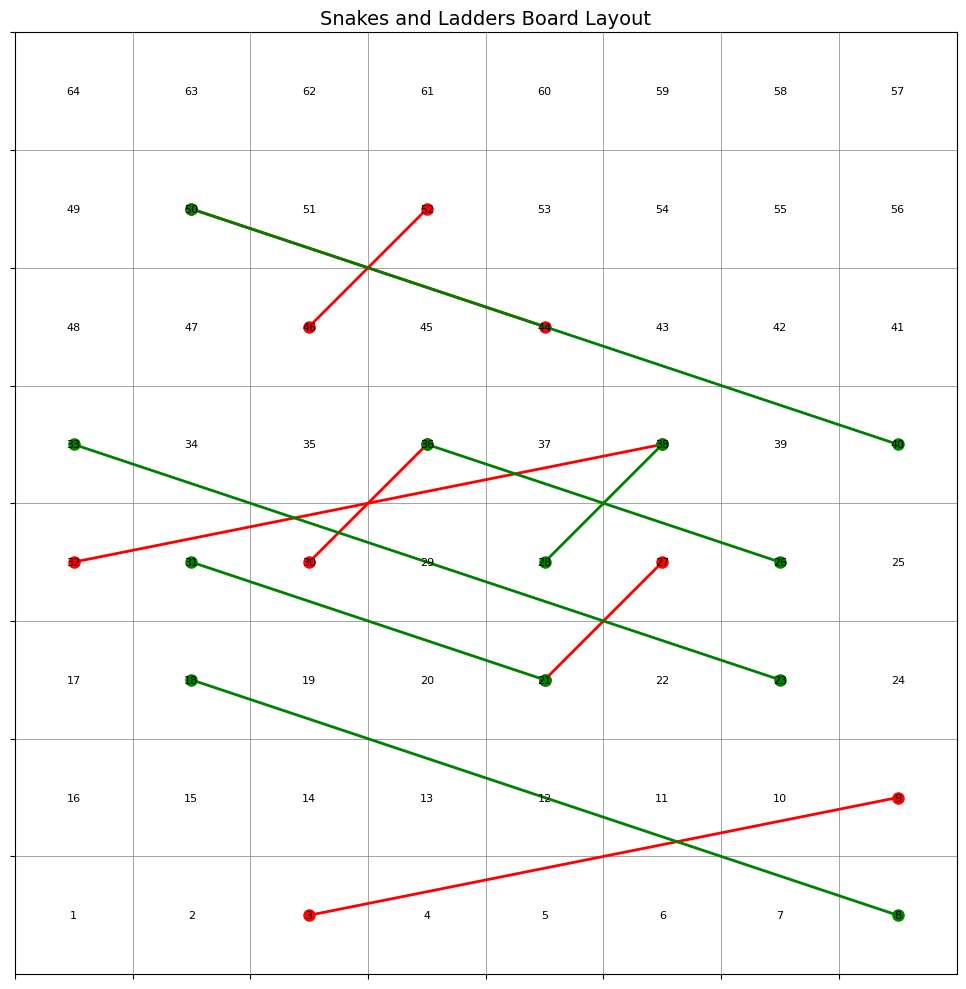


--- Board Size: 8x8, Ns/Nl Ratio: 1.0 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {33: 23, 58: 48, 13: 3, 41: 31, 52: 42, 17: 7}
Ladders: {18: 28, 44: 54, 30: 40, 26: 36, 29: 39, 6: 16}


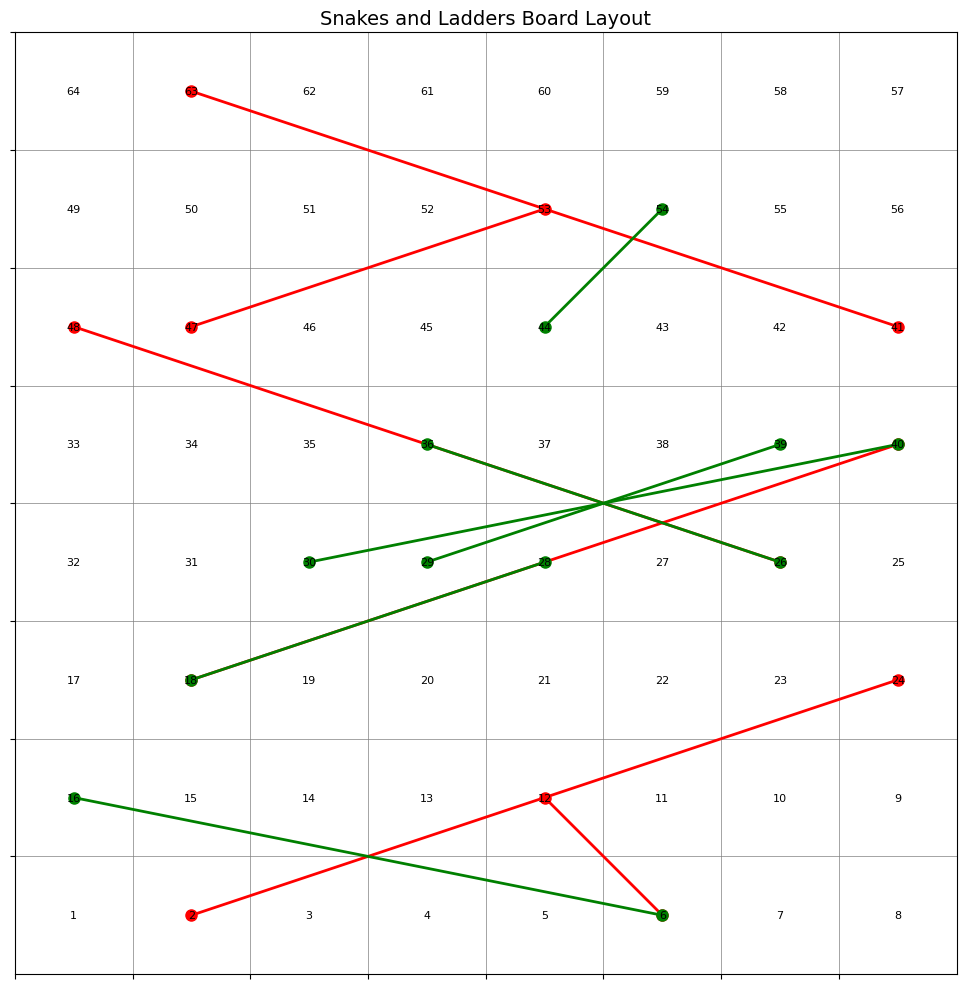


--- Board Size: 8x8, Ns/Nl Ratio: 1.5 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {39: 29, 55: 45, 36: 26, 30: 20, 23: 13, 43: 33}
Ladders: {11: 21, 50: 60, 2: 12, 42: 52}

--- Board Size: 8x8, Ns/Nl Ratio: 1.5 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {20: 10, 28: 18, 33: 23, 13: 3, 63: 53, 55: 45, 12: 2, 35: 25, 29: 19}
Ladders: {30: 40, 42: 52, 11: 21, 50: 60, 39: 49, 51: 61}

--- Board Size: 8x8, Ns/Nl Ratio: 2.0 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {35: 25, 23: 13, 16: 6, 44: 34, 53: 43, 14: 4}
Ladders: {41: 51, 32: 42, 27: 37}

--- Board Size: 8x8, Ns/Nl Ratio: 2.0 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {63: 53, 23: 1

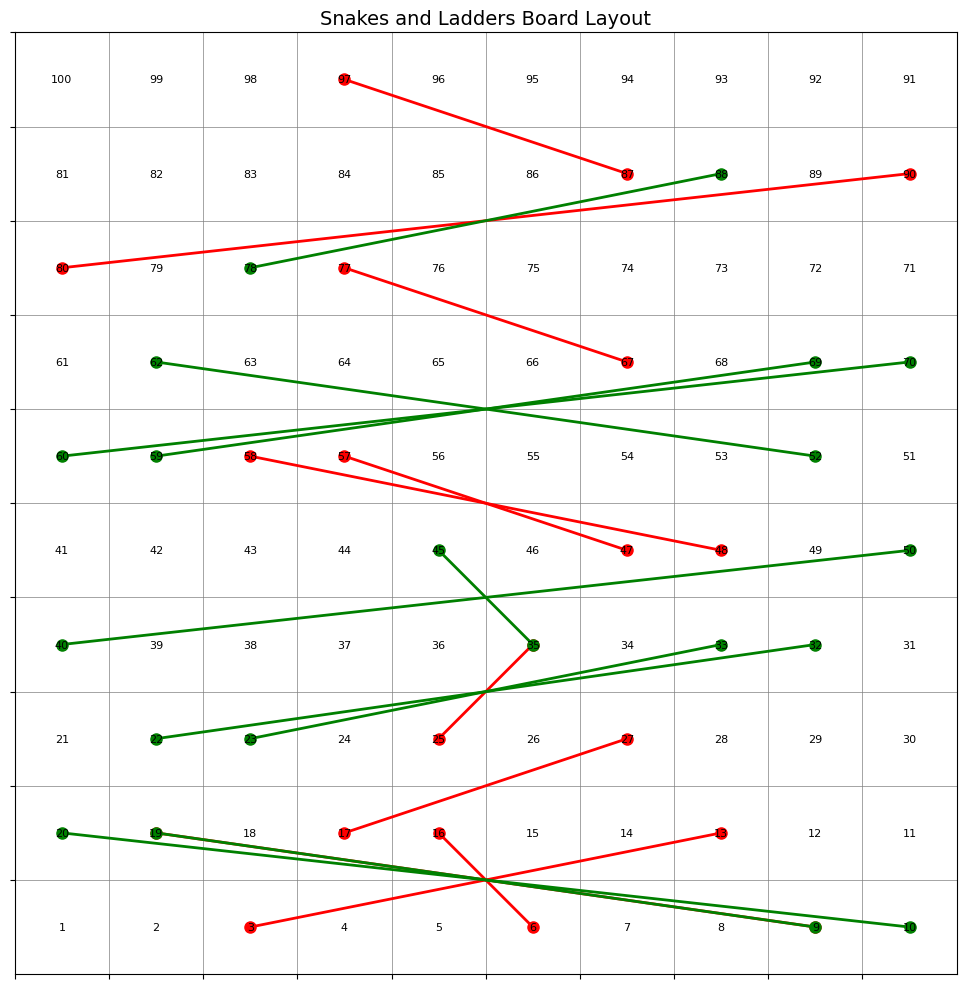


--- Board Size: 10x10, Ns/Nl Ratio: 1.0 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {81: 71, 31: 21, 28: 18, 50: 40, 75: 65, 27: 17, 46: 36, 86: 76, 57: 47, 49: 39}
Ladders: {33: 43, 51: 61, 63: 73, 62: 72, 70: 80, 42: 52, 22: 32, 44: 54, 67: 77, 69: 79}


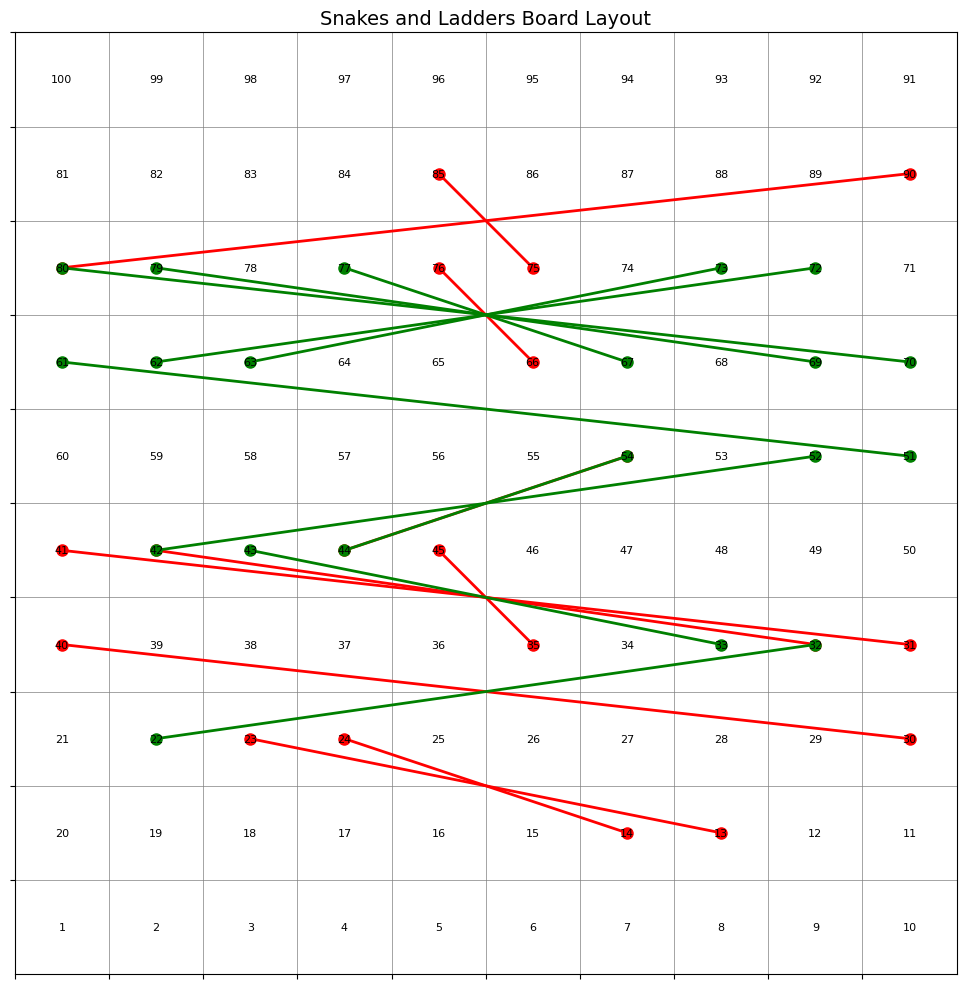


--- Board Size: 10x10, Ns/Nl Ratio: 1.5 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {99: 89, 36: 26, 56: 46, 88: 78, 12: 2, 24: 14, 93: 83, 69: 59, 55: 45, 70: 60}
Ladders: {43: 53, 28: 38, 32: 42, 81: 91, 41: 51, 84: 94}

--- Board Size: 10x10, Ns/Nl Ratio: 1.5 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {99: 89, 53: 43, 23: 13, 93: 83, 14: 4, 65: 55, 58: 48, 30: 20, 94: 84, 21: 11, 36: 26, 91: 81, 95: 85, 44: 34, 27: 17}
Ladders: {28: 38, 40: 50, 19: 29, 62: 72, 60: 70, 51: 61, 67: 77, 68: 78, 82: 92, 46: 56}

--- Board Size: 10x10, Ns/Nl Ratio: 2.0 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {93: 83, 86: 76, 18: 8, 67: 57, 16: 6, 61: 51, 52: 42, 66: 56, 48: 38, 63: 53}
Ladders: {4: 14, 24: 34, 44: 54, 35: 45, 39: 49}

---

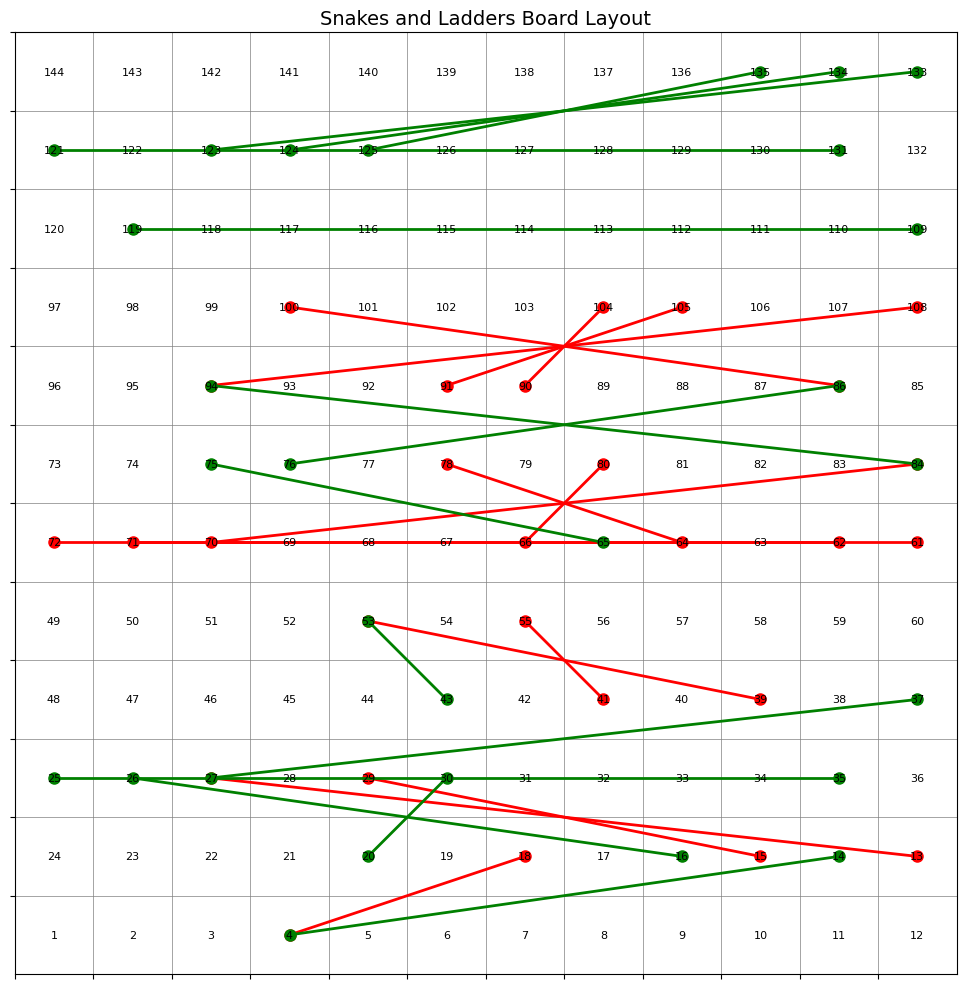


--- Board Size: 12x12, Ns/Nl Ratio: 1.0 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {83: 73, 29: 19, 64: 54, 120: 110, 100: 90, 96: 86, 14: 4, 123: 113, 42: 32, 119: 109, 136: 126, 131: 121, 67: 57, 17: 7}
Ladders: {91: 101, 88: 98, 129: 139, 127: 137, 84: 94, 68: 78, 26: 36, 33: 43, 75: 85, 15: 25, 28: 38, 79: 89, 102: 112, 20: 30}


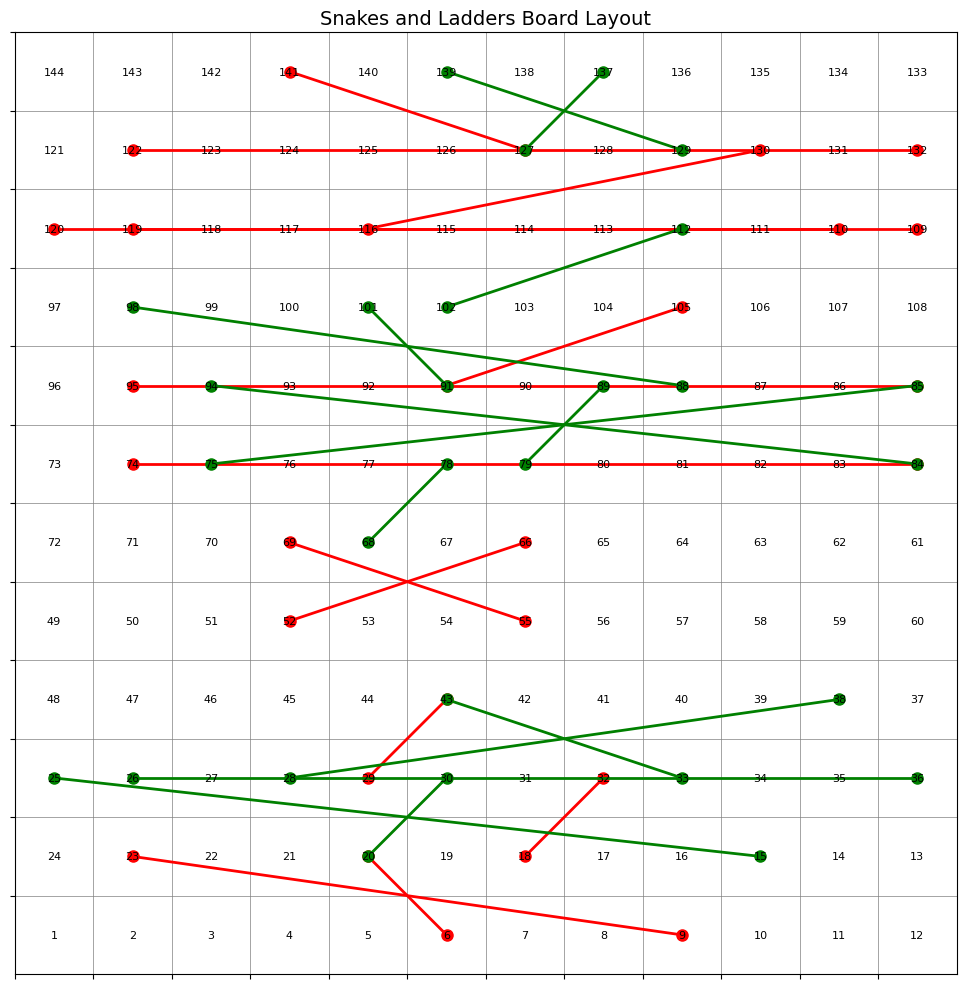


--- Board Size: 12x12, Ns/Nl Ratio: 1.5 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {57: 47, 130: 120, 81: 71, 118: 108, 16: 6, 82: 72, 48: 38, 85: 75, 33: 23, 117: 107, 122: 112, 115: 105, 93: 83, 40: 30}
Ladders: {125: 135, 129: 139, 8: 18, 3: 13, 70: 80, 126: 136, 53: 63, 104: 114, 123: 133}

--- Board Size: 12x12, Ns/Nl Ratio: 1.5 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {136: 126, 61: 51, 116: 106, 56: 46, 14: 4, 89: 79, 58: 48, 133: 123, 101: 91, 113: 103, 139: 129, 138: 128, 16: 6, 47: 37, 81: 71, 115: 105, 41: 31, 60: 50, 18: 8, 75: 65, 25: 15}
Ladders: {131: 141, 78: 88, 7: 17, 98: 108, 102: 112, 84: 94, 99: 109, 52: 62, 43: 53, 13: 23, 125: 135, 87: 97, 39: 49, 45: 55}

--- Board Size: 12x12, Ns/Nl Ratio: 2.0 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Le

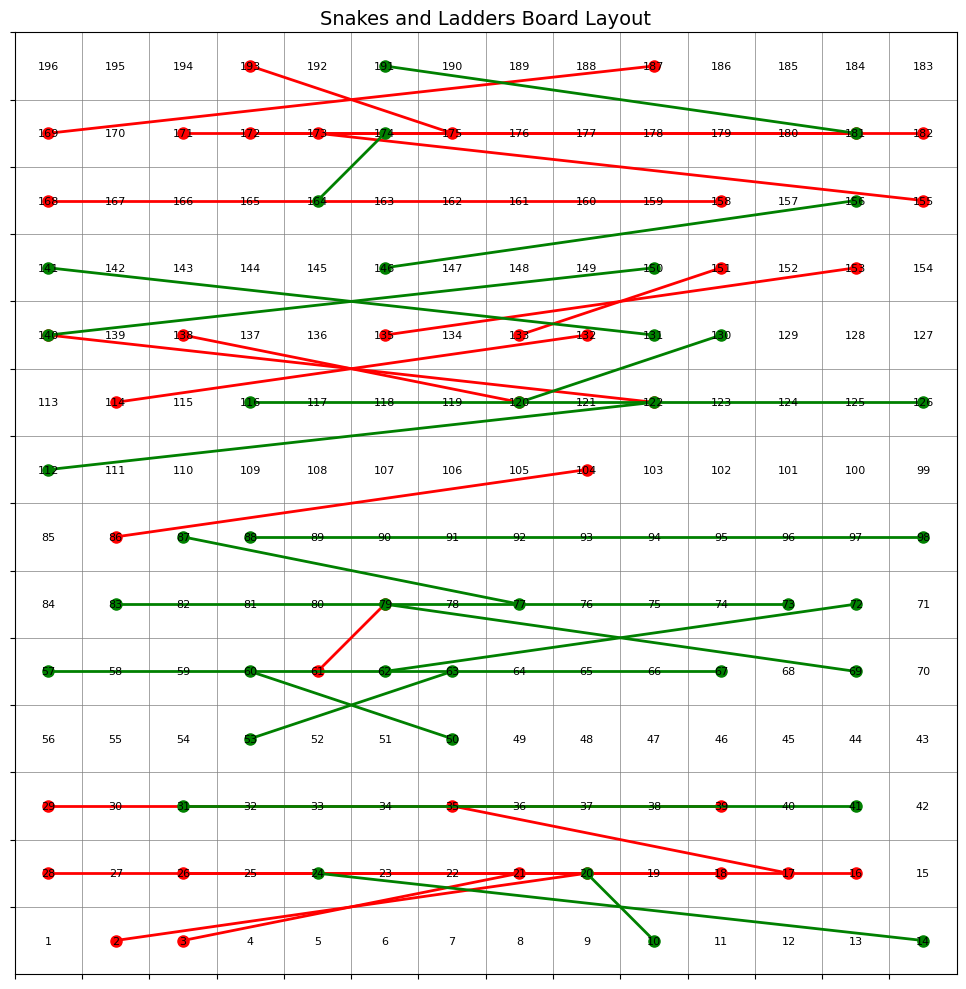


--- Board Size: 14x14, Ns/Nl Ratio: 1.0 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {146: 136, 114: 104, 121: 111, 154: 144, 63: 53, 64: 54, 97: 87, 46: 36, 108: 98, 88: 78, 145: 135, 25: 15, 45: 35, 142: 132, 106: 96, 159: 149, 69: 59, 133: 123, 130: 120}
Ladders: {147: 157, 61: 71, 162: 172, 119: 129, 160: 170, 72: 82, 19: 29, 182: 192, 50: 60, 168: 178, 124: 134, 65: 75, 140: 150, 174: 184, 90: 100, 138: 148, 56: 66, 180: 190, 92: 102}


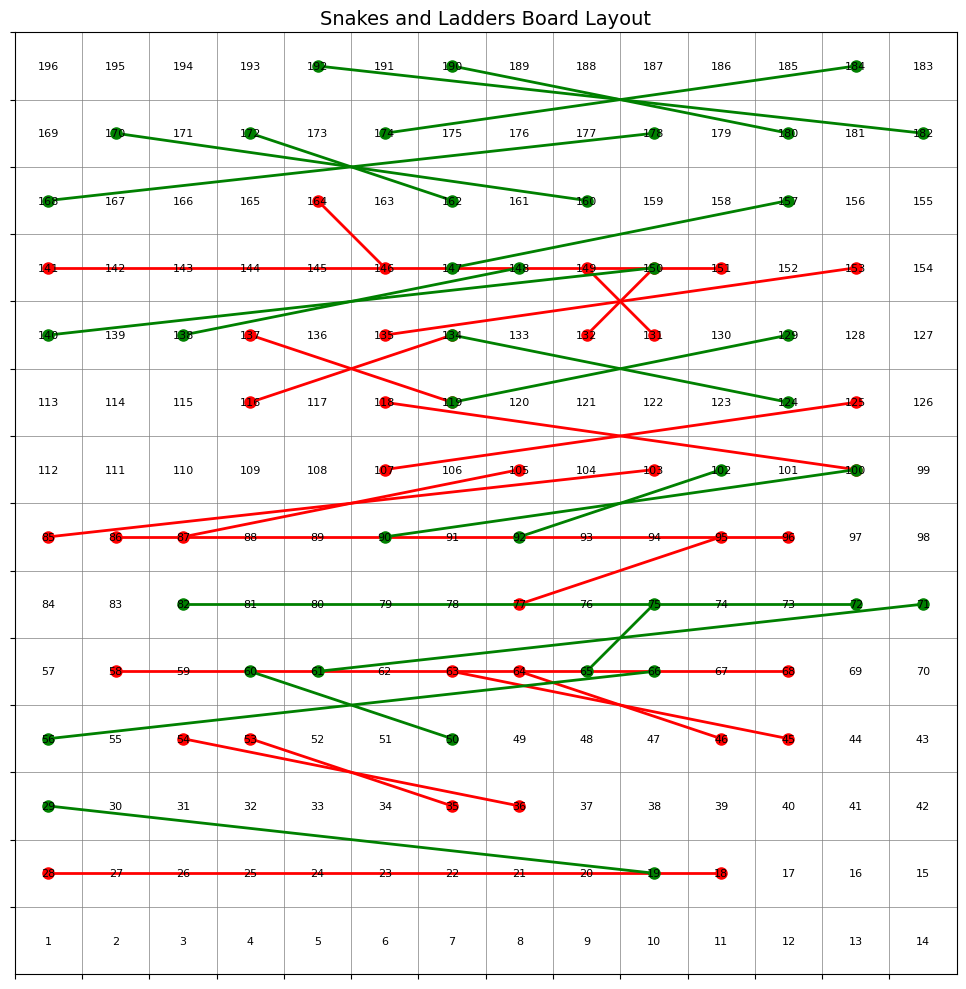


--- Board Size: 14x14, Ns/Nl Ratio: 1.5 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {173: 163, 129: 119, 18: 8, 94: 84, 31: 21, 126: 116, 65: 55, 172: 162, 168: 158, 144: 134, 103: 93, 59: 49, 175: 165, 77: 67, 151: 141, 26: 16, 62: 52, 159: 149, 50: 40}
Ladders: {121: 131, 97: 107, 27: 37, 101: 111, 160: 170, 108: 118, 29: 39, 51: 61, 95: 105, 48: 58, 35: 45, 135: 145}

--- Board Size: 14x14, Ns/Nl Ratio: 1.5 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {153: 143, 167: 157, 41: 31, 76: 66, 189: 179, 43: 33, 175: 165, 34: 24, 46: 36, 124: 114, 190: 180, 17: 7, 115: 105, 69: 59, 13: 3, 54: 44, 113: 103, 19: 9, 139: 129, 166: 156, 168: 158, 160: 150, 55: 45, 20: 10, 154: 144, 60: 50, 16: 6, 97: 87}
Ladders: {131: 141, 162: 172, 120: 130, 132: 142, 52: 62, 125: 135, 2: 12, 8: 18, 81: 91, 82: 92, 161: 171, 116: 126,

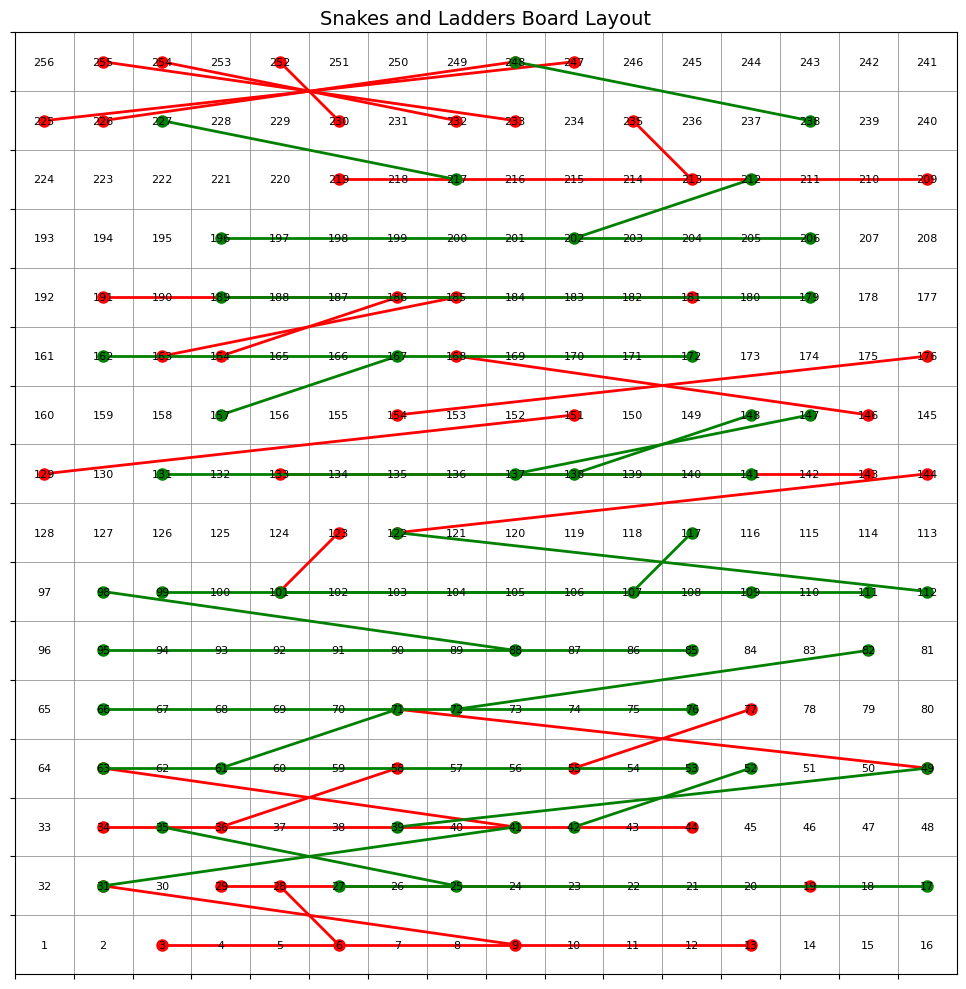


--- Board Size: 16x16, Ns/Nl Ratio: 1.0 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {212: 202, 181: 171, 57: 47, 63: 53, 189: 179, 177: 167, 33: 23, 90: 80, 123: 113, 176: 166, 219: 209, 235: 225, 162: 152, 48: 38, 108: 98, 14: 4, 135: 125, 21: 11, 131: 121, 243: 233, 55: 45, 109: 99, 208: 198, 254: 244, 200: 190}
Ladders: {19: 29, 143: 153, 137: 147, 86: 96, 7: 17, 146: 156, 204: 214, 81: 91, 155: 165, 231: 241, 78: 88, 140: 150, 64: 74, 159: 169, 218: 228, 22: 32, 217: 227, 237: 247, 151: 161, 107: 117, 110: 120, 69: 79, 31: 41, 44: 54, 220: 230}


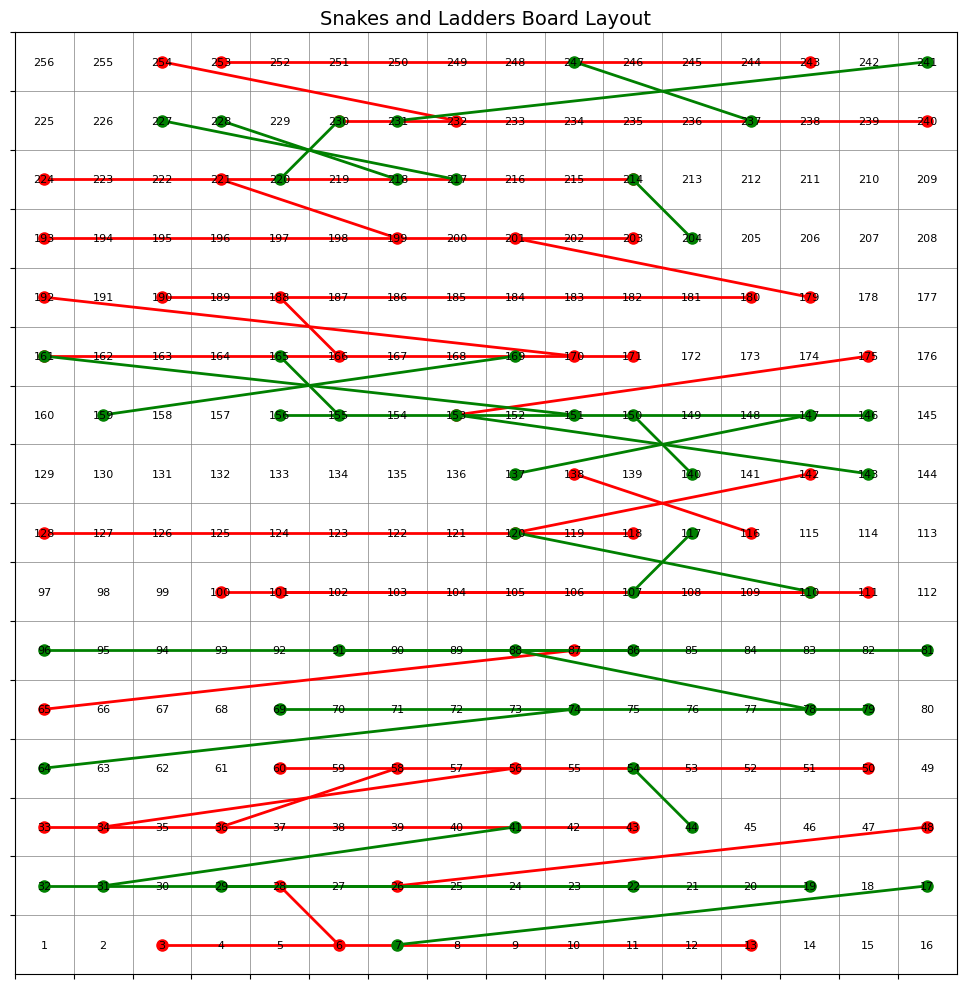


--- Board Size: 16x16, Ns/Nl Ratio: 1.5 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {151: 141, 184: 174, 182: 172, 75: 65, 76: 66, 241: 231, 112: 102, 226: 216, 13: 3, 229: 219, 91: 81, 181: 171, 95: 85, 180: 170, 157: 147, 21: 11, 60: 50, 254: 244, 188: 178, 223: 213, 217: 207, 144: 134, 41: 31, 183: 173, 131: 121}
Ladders: {54: 64, 86: 96, 98: 108, 140: 150, 15: 25, 158: 168, 240: 250, 149: 159, 51: 61, 120: 130, 119: 129, 49: 59, 201: 211, 224: 234, 104: 114, 48: 58}

--- Board Size: 16x16, Ns/Nl Ratio: 1.5 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {247: 237, 75: 65, 36: 26, 70: 60, 232: 222, 104: 94, 190: 180, 31: 21, 19: 9, 251: 241, 66: 56, 33: 23, 253: 243, 130: 120, 135: 125, 231: 221, 246: 236, 179: 169, 126: 116, 78: 68, 90: 80, 188: 178, 143: 133, 235: 225, 35: 25, 219: 209, 171: 161, 228: 218, 15:

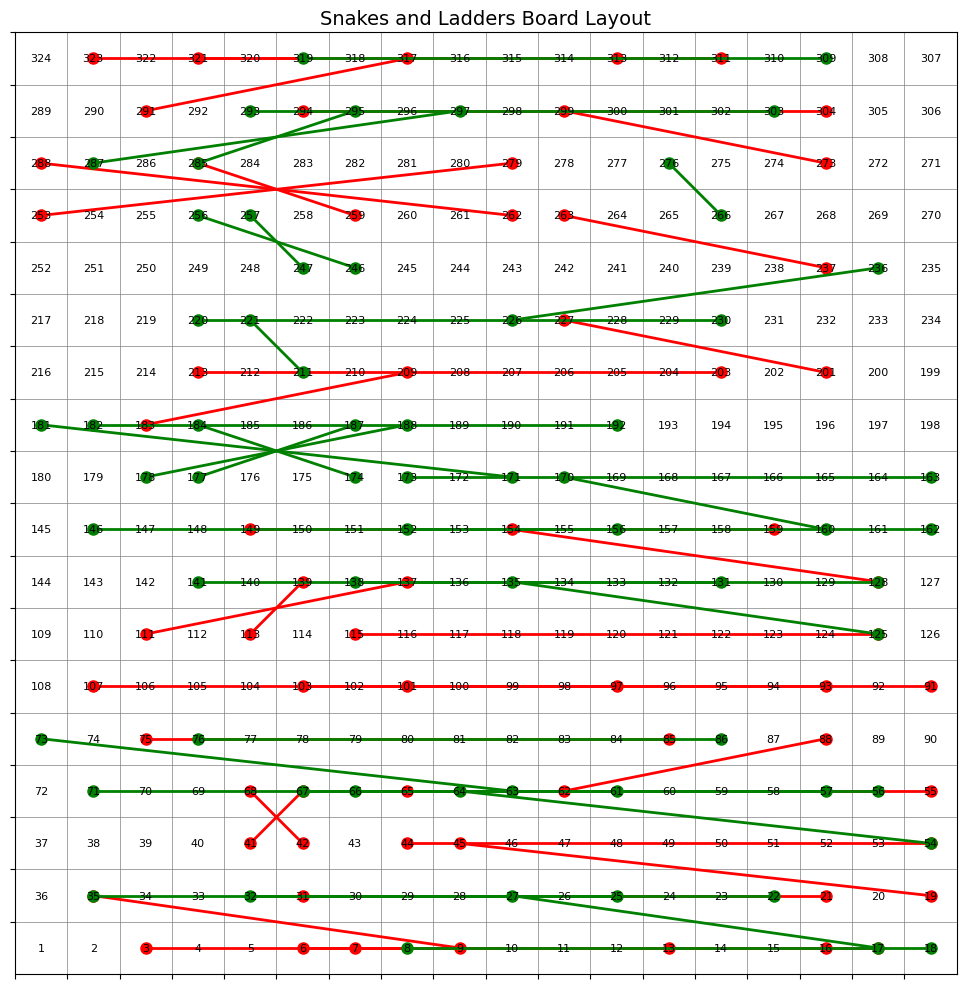


--- Board Size: 18x18, Ns/Nl Ratio: 1.0 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {110: 100, 86: 76, 317: 307, 193: 183, 78: 68, 271: 261, 161: 151, 272: 262, 28: 18, 237: 227, 302: 292, 133: 123, 25: 15, 215: 205, 251: 241, 164: 154, 217: 207, 310: 300, 286: 276, 284: 274, 71: 61, 147: 137, 158: 148, 56: 46, 119: 109, 82: 72, 99: 89, 165: 155, 167: 157, 288: 278, 280: 270, 252: 242}
Ladders: {313: 323, 125: 135, 239: 249, 311: 321, 283: 293, 243: 253, 75: 85, 247: 257, 31: 41, 196: 206, 6: 16, 267: 277, 178: 188, 223: 233, 101: 111, 49: 59, 281: 291, 269: 279, 55: 65, 22: 32, 248: 258, 47: 57, 234: 244, 189: 199, 190: 200, 121: 131, 102: 112, 236: 246, 174: 184, 13: 23, 181: 191, 67: 77}


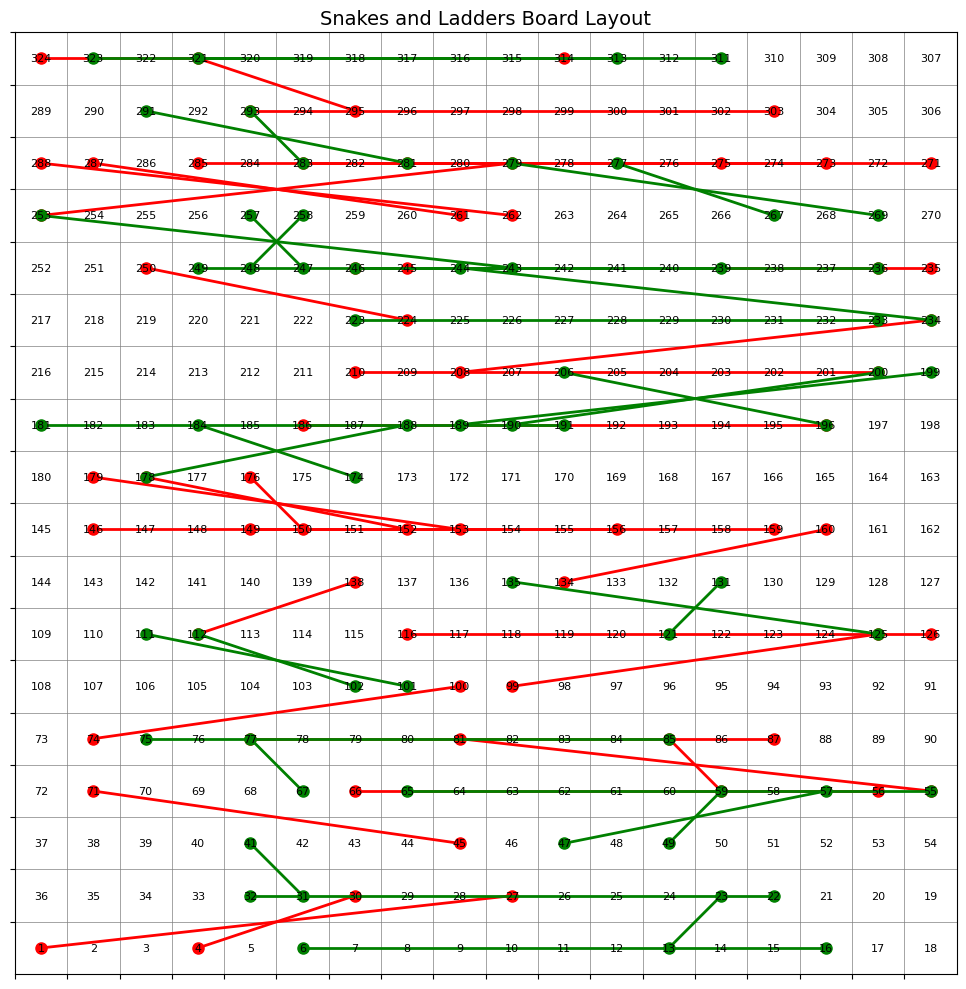


--- Board Size: 18x18, Ns/Nl Ratio: 1.5 (Fixed Snakes Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {190: 180, 312: 302, 169: 159, 307: 297, 228: 218, 50: 40, 289: 279, 213: 203, 25: 15, 225: 215, 249: 239, 104: 94, 118: 108, 49: 39, 72: 62, 87: 77, 210: 200, 252: 242, 270: 260, 214: 204, 266: 256, 127: 117, 316: 306, 293: 283, 65: 55, 258: 248, 140: 130, 247: 237, 314: 304, 195: 185, 73: 63, 126: 116}
Ladders: {291: 301, 268: 278, 288: 298, 28: 38, 70: 80, 68: 78, 211: 221, 32: 42, 177: 187, 198: 208, 113: 123, 91: 101, 164: 174, 74: 84, 255: 265, 137: 147, 222: 232, 92: 102, 7: 17, 240: 250, 168: 178}

--- Board Size: 18x18, Ns/Nl Ratio: 1.5 (Fixed Ladders Density) ---

Simulation Board Configuration (Fixed Lengths):
Fixed Snake Length: 10, Fixed Ladder Length: 10
Snakes: {45: 35, 148: 138, 241: 231, 190: 180, 243: 233, 312: 302, 46: 36, 37: 27, 26: 16, 60: 50, 96: 86, 90: 80, 287: 277, 130: 120, 317: 307, 162: 

In [ ]:
def run_analysis():
    """
    Run the complete analysis with both simulation types.
    """
    all_results_list = [] # List to store metrics for each board size

    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size)) # Calculate square_side here

        metrics_ratio_fixed_snakes_board_size = [] # Metrics for each ratio, fixed snake density
        metrics_ratio_fixed_ladders_board_size = [] # Metrics for each ratio, fixed ladder density

        for ns_nl_ratio in NS_NL_RATIOS: # Iterate through Ns/Nl ratios

            # --- Simulations with FIXED SNAKE DENSITY ---
            num_snakes = int(NUM_SNAKES_LADDERS_DENSITY * board_size) # Fixed snake density
            num_ladders = int(num_snakes / ns_nl_ratio) # Ladders based on ratio

            turn_counts_simulation = []
            all_positions_visited = []
            all_entity_triggers = []

            snakes, ladders = create_snakes_and_ladders(board_size, num_snakes, num_ladders, FIXED_SNAKE_LENGTH, FIXED_LADDER_LENGTH) # Pass fixed lengths

            print(f"\n--- Board Size: {square_side}x{square_side}, Ns/Nl Ratio: {ns_nl_ratio:.1f} (Fixed Snakes Density) ---")
            print("\nSimulation Board Configuration (Fixed Lengths):")
            print(f"Fixed Snake Length: {FIXED_SNAKE_LENGTH}, Fixed Ladder Length: {FIXED_LADDER_LENGTH}")
            print("Snakes:", {k: v for k, v in snakes.items()})
            print("Ladders:", {k: v for k, v in ladders.items()})

            if ns_nl_ratio == 1.0: # Conditional board plot - NEW: Check ns_nl_ratio
                labeled_board_plt = plot_board_layout_matplotlib(board_size, snakes, ladders)
                labeled_board_plt.show()

            for _ in range(NUM_SIMULATIONS):
                turns, positions, triggers = simulate_game(board_size, snakes, ladders,
                                                         record_positions=True,
                                                         record_entity_triggers=True)
                turn_counts_simulation.append(turns)
                all_positions_visited.append(positions)
                all_entity_triggers.append(triggers)

            avg_turns_simulation = sum(turn_counts_simulation) / NUM_SIMULATIONS
            prob_win_half_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 2) # n/2 turns
            prob_win_third_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 3) # n/3 turns
            prob_win_quarter_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 4) # n/4 turns

            board_metrics = {
                "board_size": board_size,
                "num_snakes": num_snakes,
                "num_ladders": num_ladders,
                "ns_nl_ratio": ns_nl_ratio, # Store Ns/Nl Ratio - NEW
                "fixed_snake_length": FIXED_SNAKE_LENGTH,
                "fixed_ladder_length": FIXED_LADDER_LENGTH,
                "simulation_type": "fixed_snake_density", # Indicate density type - NEW
                "average_turns": avg_turns_simulation, # Changed key name for consistency
                "prob_win_half_turns": prob_win_half_turns,
                "prob_win_third_turns": prob_win_third_turns,
                "prob_win_quarter_turns": prob_win_quarter_turns
            }
            metrics_ratio_fixed_snakes_board_size.append(board_metrics) # Append to board size list - NEW


            # --- Simulations with FIXED LADDER DENSITY ---
            num_ladders = int(NUM_SNAKES_LADDERS_DENSITY * board_size) # Fixed ladder density
            num_snakes = int(num_ladders * ns_nl_ratio) # Snakes based on ratio

            turn_counts_simulation = []
            all_positions_visited = []
            all_entity_triggers = []

            snakes, ladders = create_snakes_and_ladders(board_size, num_snakes, num_ladders, FIXED_SNAKE_LENGTH, FIXED_LADDER_LENGTH) # Pass fixed lengths

            print(f"\n--- Board Size: {square_side}x{square_side}, Ns/Nl Ratio: {ns_nl_ratio:.1f} (Fixed Ladders Density) ---") # Indicate board size and ratio
            print("\nSimulation Board Configuration (Fixed Lengths):")
            print(f"Fixed Snake Length: {FIXED_SNAKE_LENGTH}, Fixed Ladder Length: {FIXED_LADDER_LENGTH}")
            print("Snakes:", {k: v for k, v in snakes.items()})
            print("Ladders:", {k: v for k, v in ladders.items()})

            if ns_nl_ratio == 1.0: # Conditional board plot - NEW: Check ns_nl_ratio, removed redundant display_labeled_board condition
                labeled_board_plt = plot_board_layout_matplotlib(board_size, snakes, ladders) # Use line-based layout plot
                labeled_board_plt.show()

            for _ in range(NUM_SIMULATIONS):
                turns, positions, triggers = simulate_game(board_size, snakes, ladders,
                                                         record_positions=True,
                                                         record_entity_triggers=True)
                turn_counts_simulation.append(turns)
                all_positions_visited.append(positions)
                all_entity_triggers.append(triggers)

            avg_turns_simulation = sum(turn_counts_simulation) / NUM_SIMULATIONS
            prob_win_half_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 2) # n/2 turns
            prob_win_third_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 3) # n/3 turns
            prob_win_quarter_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 4) # n/4 turns


            board_metrics = {
                "board_size": board_size,
                "num_snakes": num_snakes,
                "num_ladders": num_ladders,
                "ns_nl_ratio": ns_nl_ratio, # Store Ns/Nl Ratio - NEW
                "fixed_snake_length": FIXED_SNAKE_LENGTH,
                "fixed_ladder_length": FIXED_LADDER_LENGTH,
                "simulation_type": "fixed_ladder_density", # Indicate density type - NEW
                "average_turns": avg_turns_simulation, # Changed key name for consistency
                "prob_win_half_turns": prob_win_half_turns,
                "prob_win_third_turns": prob_win_third_turns,
                "prob_win_quarter_turns": prob_win_quarter_turns
            }
            metrics_ratio_fixed_ladders_board_size.append(board_metrics) # Append to board size list - NEW


        all_results_list.append(metrics_ratio_fixed_snakes_board_size + metrics_ratio_fixed_ladders_board_size) # Combine metrics for both density types


    results_df = pd.DataFrame([item for sublist in all_results_list for item in sublist]) # Flatten list of lists into DataFrame
    return results_df # Return DataFrame of metrics


if __name__ == "__main__":
    results_df = run_analysis()

    # Save results to CSV for further analysis if needed
    results_df.to_csv("snakes_ladders_simulation_results.csv", index=False)

    print("\nAnalysis complete. Results saved to 'snakes_ladders_simulation_results.csv'")

    # --- Analyze and Present Metrics Across Board Sizes ---

    # Plotting Trends - Fixed Snakes Density
    for board_size in BOARD_SIZES:
        plot_win_probability_vs_ratio(results_df, board_size, "all", "fixed_snake_density")
        plt.show()

    plot_win_probability_vs_ratio_combined(results_df, "fixed_snake_density")
    plt.show()


    # Plotting Trends - Fixed Ladders Density
    for board_size in BOARD_SIZES:
        plot_win_probability_vs_ratio(results_df, board_size, "all", "fixed_ladder_density")
        plt.show()

    plot_win_probability_vs_ratio_combined(results_df, "fixed_ladder_density")
    plt.show()